# Denoising Dirty Documents with AutoEncoders 📜➡📃

- dataset - https://www.kaggle.com/c/denoising-dirty-documents/data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # ไว้แสดง progress bar

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D,
                                     Dropout, Conv2DTranspose)
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
%ls '/content/drive/MyDrive/ColabNotebooks/denoising-dirty-documents'

test/  train/  train_cleaned/


In [6]:
path = '/content/drive/MyDrive/ColabNotebooks/denoising-dirty-documents/'

In [7]:
# ขนาดรูป
# imgW, imgH = 300, 240
imgW, imgH = 540, 420

- เก็บชื่อไฟล์รูปภาพจาก folder ในรูปแบบ list แล้วนับจำนวนรูปทั้งหมด

In [8]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

print(f'X Train: {len(train_img)} , Y Train: {len(train_cleaned_img)}')
print('X Test:', len(test_img))

train_img[:5]

X Train: 144 , Y Train: 144
X Test: 72


['101.png', '102.png', '104.png', '105.png', '107.png']

- ดูภาพตัวอย่าง

(420, 540, 1)


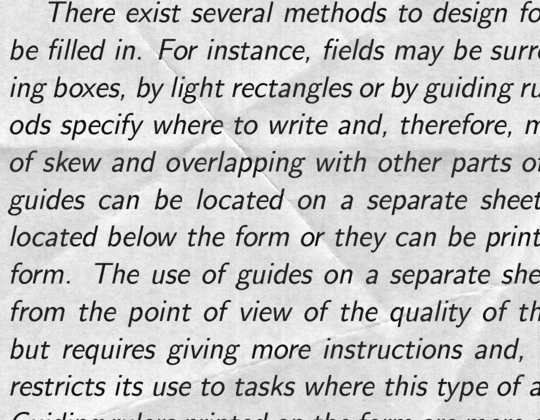

In [9]:
# จาก train
img = load_img(path+'train/'+train_img[0], target_size=(imgH, imgW), # ภาพ index ที่ 0
              color_mode='grayscale')
print(img_to_array(img).shape)

img

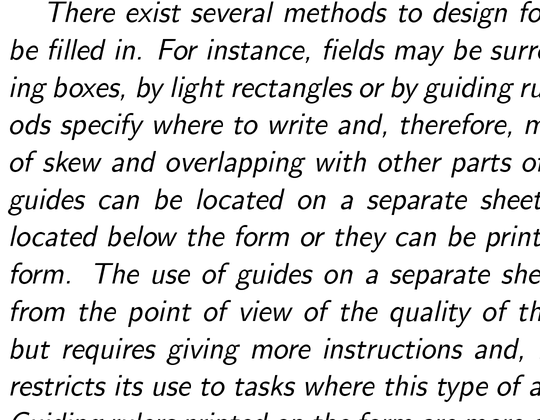

In [10]:
# จาก train_cleaned
img = load_img(path+'train_cleaned/'+train_img[0], target_size=(imgH, imgW)) # ภาพ index ที่ 0
img

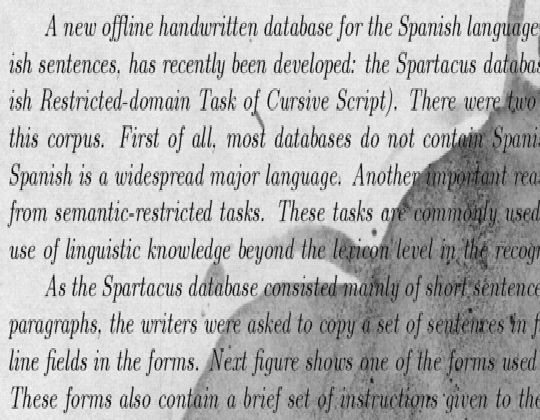

In [11]:
# จาก test
img = load_img(path+'test/'+test_img[0], target_size=(imgH, imgW)) # ภาพ index ที่ 0
img

## Preprocess image

In [12]:
def process_image(file):
    img = load_img(file, target_size=(imgH, imgW), color_mode='grayscale') # อ่านเป็น grayscale
    img = img_to_array(img) # เปลี่ยนเป็น array
    img = img/255.0 # normalize ภาพ
    return img

In [13]:
train = []
train_cleaned = []
test = []

# อ่านไฟล์รูปแล้วเข้า process_image() ฟังก์ชั่น
for f in tqdm(train_img):
    train.append(process_image(path + 'train/' + f))

for f in tqdm(train_cleaned_img):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))

for f in tqdm(test_img):
    test.append(process_image(path + 'test/' + f))

# tqdm ไว้แสดง progress bar

100%|██████████| 72/72 [00:23<00:00,  3.09it/s]


In [14]:
print('Train0 shape:', train[0].shape)

Train0 shape: (420, 540, 1)


- plot รูปจาก train และ train_cleaned

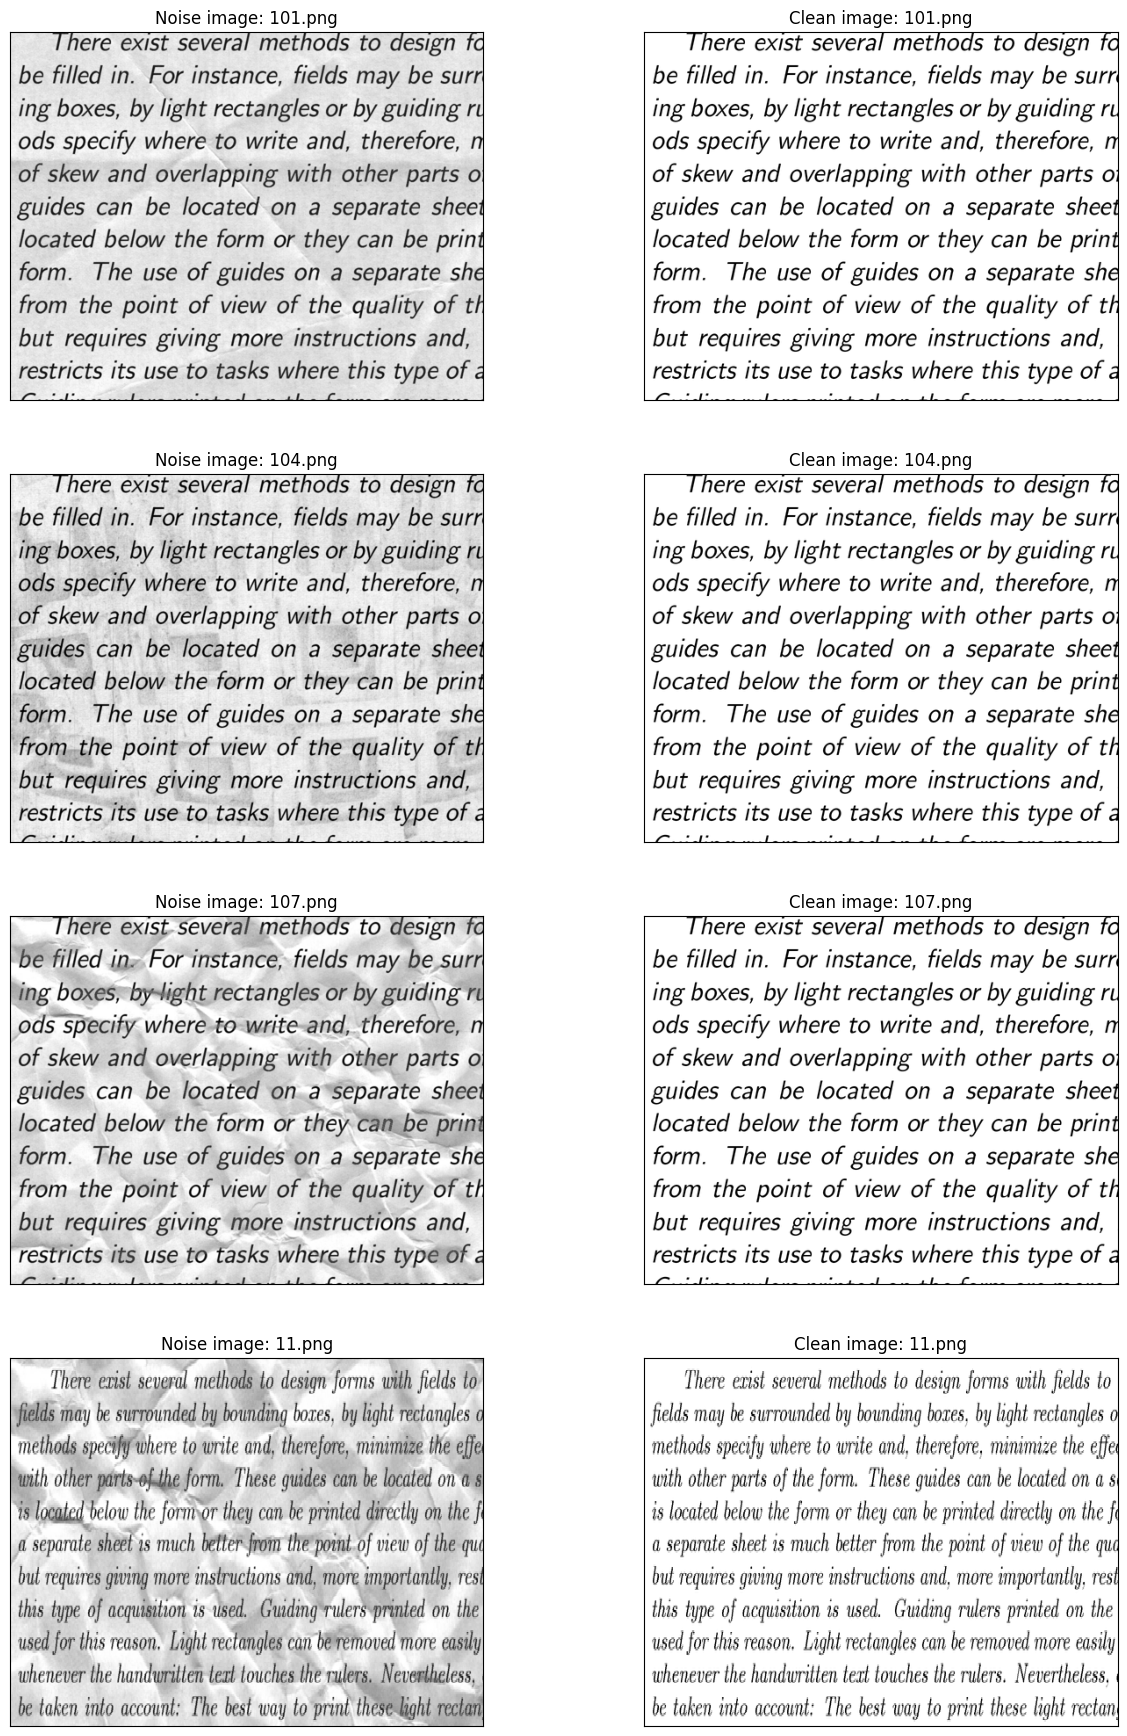

In [15]:
plt.figure(figsize=(15,22))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Clean image: {}'.format(train_img[i]))

plt.show()

## แบ่งข้อมูล Train และ Validate

In [16]:
# เปลี่ยนจาก list เป็น numpy array
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

# แบ่งข้อมูล
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15) #  15% ของข้อมูล train จะถูกใช้เป็น val และ 85% ที่เหลือเป็น train set

X_train.shape, X_val.shape

((122, 420, 540, 1), (22, 420, 540, 1))

## Model

ในการ train model จะใช้ข้อมูล..
- train (รูปที่มี noise ในเอกสาร) เป็น X
- train_cleaned (รูปที่ไม่มี noise ในเอกสาร) เป็น Y

เพื่อเป็นการสอน model ว่าเราอยากได้ output เป็นแบบ train_cleaned นะ หรือก็คือ รูปที่ไม่มี noise ในเอกสาร

In [17]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()

        # Encoder
        self.encoder = Sequential([
            # InputLayer(input_shape=(imgW, imgH, 1)),
            Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            # BatchNormalization(),
            # MaxPooling2D((2, 2), padding='same'),
            Dropout(0.4) ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
callback = EarlyStopping(monitor='loss', patience=20)
history = autoencoder.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 25s 1s/step - loss: 0.5538 - val_loss: 0.3584
Epoch 2/100
8/8 [==============================] - 4s 515ms/step - loss: 0.3537 - val_loss: 0.3480
Epoch 3/100
8/8 [==============================] - 4s 522ms/step - loss: 0.3256 - val_loss: 0.3192
Epoch 4/100
8/8 [==============================] - 4s 512ms/step - loss: 0.3072 - val_loss: 0.2998
Epoch 5/100
8/8 [==============================] - 4s 512ms/step - loss: 0.2804 - val_loss: 0.2615
Epoch 6/100
8/8 [==============================] - 4s 521ms/step - loss: 0.2443 - val_loss: 0.2189
Epoch 7/100
8/8 [==============================] - 4s 516ms/step - loss: 0.2115 - val_loss: 0.1960
Epoch 8/100
8/8 [==============================] - 4s 529ms/step - loss: 0.1932 - val_loss: 0.1828
Epoch 9/100
8/8 [==============================] - 4s 530ms/step - loss: 0.1808 - val_loss: 0.1707
Epoch 10/100
8/8 [==============================] - 4s 527ms/step - loss: 0.1707 - val_loss: 0.1608
Epoch 11/10

In [19]:
# บันทึก model
autoencoder.save('autoencoder_model')

เมื่อบันทึกแล้วจะได้เป็น folder ชื่อ autoencoder_model มา ซึ่งใน colab มันกดโหลดเป็น folder ไม่ได้ เลยต้องบีบเป็น .zip ก่อน

In [20]:
!zip -r /content/autoencoder_model.zip /content/autoencoder_model

  adding: content/autoencoder_model/ (stored 0%)
  adding: content/autoencoder_model/saved_model.pb (deflated 88%)
  adding: content/autoencoder_model/assets/ (stored 0%)
  adding: content/autoencoder_model/variables/ (stored 0%)
  adding: content/autoencoder_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/autoencoder_model/variables/variables.index (deflated 64%)
  adding: content/autoencoder_model/keras_metadata.pb (deflated 91%)
  adding: content/autoencoder_model/fingerprint.pb (stored 0%)


In [21]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 210, 270, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 135, 128)     73856     
                                                                 
 dropout (Dropout)           (None, 105, 135, 128)     0         
                                                                 
Total params: 74496 (291.00 KB)
Trainable params: 74496 (291.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 210, 270, 128)     147584    
 anspose)                                                     

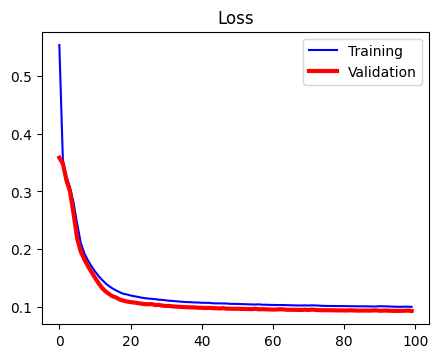

In [22]:
plt.figure(figsize=(5, 3.8))
plt.plot(history.history['loss'], color='b', label="Training")
plt.plot(history.history['val_loss'], 'r', lw=3, label="Validation")
plt.title('Loss')
plt.legend()
plt.show()

## ลองใช้กับ X_test

In [23]:
# clean test images
Y_pred = autoencoder.predict(X_test, batch_size=16)

5/5 [==============================] - 2s 391ms/step


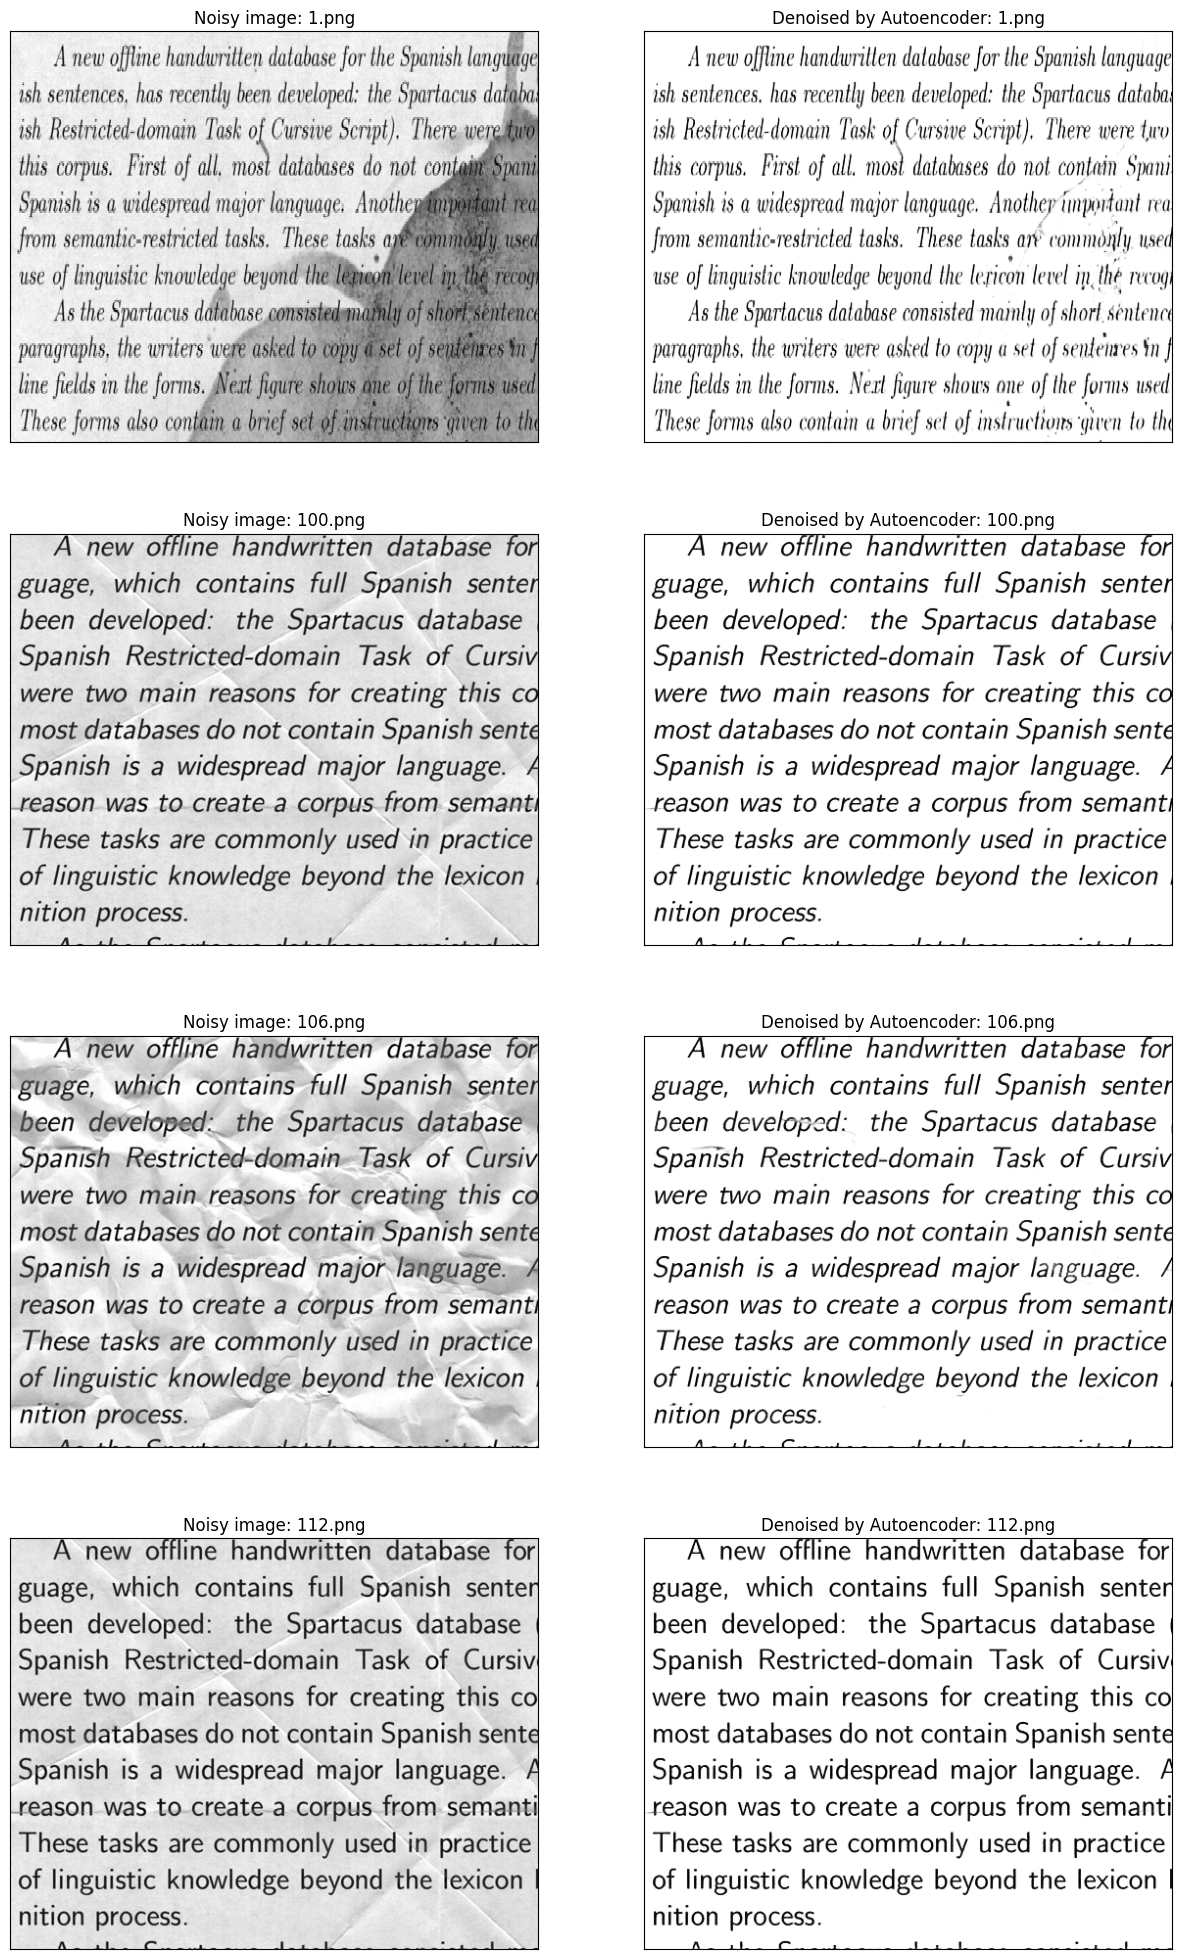

In [24]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by Autoencoder: {}'.format(test_img[i]))

plt.show()

## ลองใช้กับภาพของตัวเอง

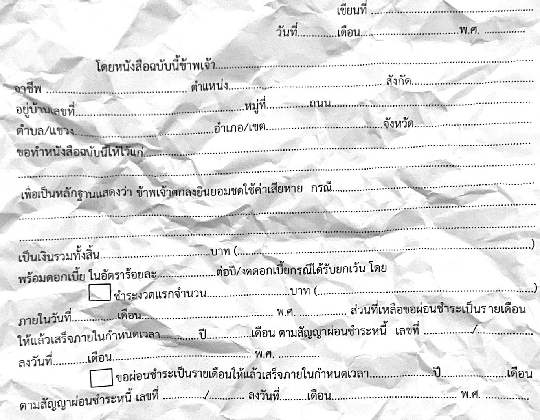

In [27]:
img = load_img('/content/S__331284511.jpg', target_size=(imgH, imgW), color_mode='grayscale') # อ่านเป็น grayscale
img

In [28]:
img = img_to_array(img) # เปลี่ยนเป็น array
img = img/255.0 # normalize ภาพ
print(img.shape)
print(np.max(img), np.min(img))

(420, 540, 1)
1.0 0.0


In [29]:
img = np.expand_dims(img, axis=0) # reshape ให้เป็นข้อมูล 1 row (1 sample) ให้เป็น (1,420,540,1)
img.shape

(1, 420, 540, 1)

1/1 [==============================] - 0s 401ms/step
(420, 540)


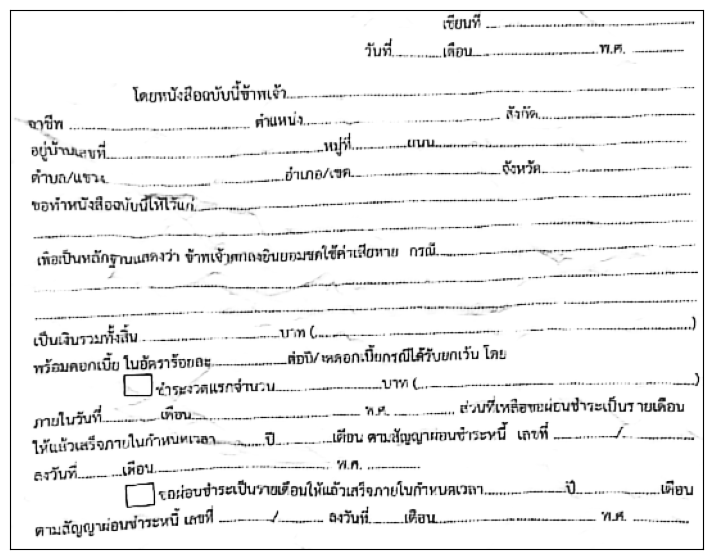

In [30]:
Y_pred = autoencoder.predict(img) # เรียกใช้ autoencoder
Y_pred = np.squeeze(Y_pred)
print(Y_pred.shape)

# รูปที่ได้
plt.figure(figsize=(10, 7))
plt.imshow(Y_pred, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

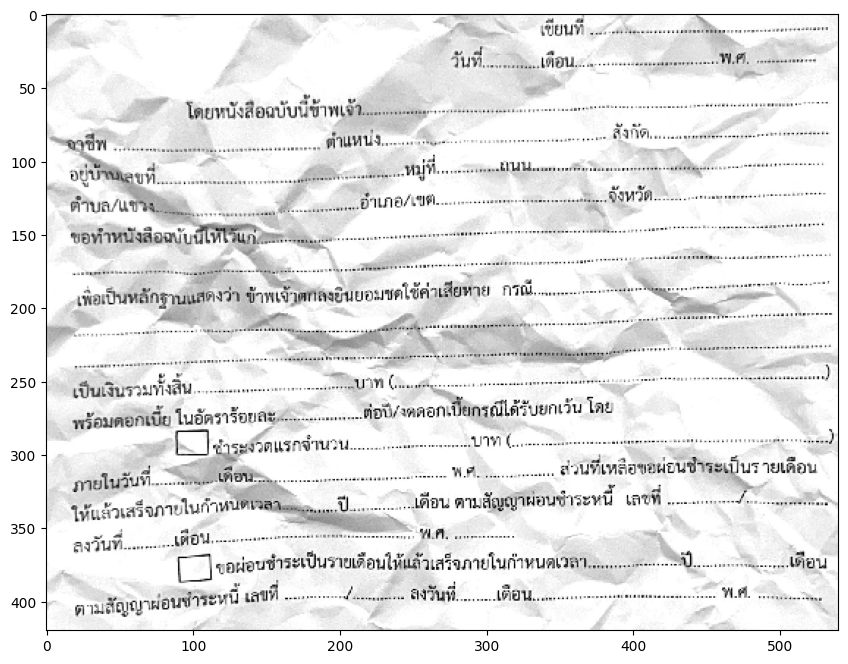

In [31]:
# รูปเดิม
plt.figure(figsize=(12, 8))
plt.imshow(np.squeeze(img), cmap='gray')
plt.show()

## load model มาใช้ต่อ

unzip ไฟล์ autoencoder_model.zip ที่มาจากการ train

In [2]:
!unzip /content/autoencoder_model.zip -d /content/autoencoder_model

Archive:  /content/autoencoder_model.zip
   creating: /content/autoencoder_model/autoencoder_model/
   creating: /content/autoencoder_model/autoencoder_model/assets/
   creating: /content/autoencoder_model/autoencoder_model/content/
  inflating: /content/autoencoder_model/autoencoder_model/fingerprint.pb  
  inflating: /content/autoencoder_model/autoencoder_model/keras_metadata.pb  
  inflating: /content/autoencoder_model/autoencoder_model/saved_model.pb  
   creating: /content/autoencoder_model/autoencoder_model/variables/
  inflating: /content/autoencoder_model/autoencoder_model/variables/variables.data-00000-of-00001  
  inflating: /content/autoencoder_model/autoencoder_model/variables/variables.index  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # ไว้แสดง progress bar

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D,
                                     Dropout, Conv2DTranspose)
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
from tensorflow.keras.models import load_model

# โหลด model
loaded_autoencoder = load_model('/content/autoencoder_model/autoencoder_model/')

In [4]:
# imgW, imgH = 300, 240
imgW, imgH = 540, 420

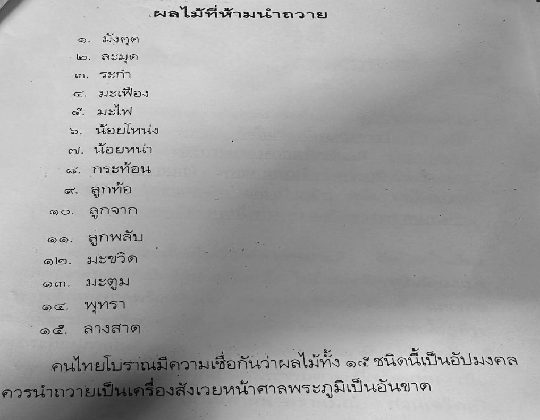

In [5]:
img = load_img('/content/111443_0.jpg', target_size=(imgH, imgW), color_mode='grayscale') # อ่านเป็น grayscale
img

In [6]:
img = img_to_array(img) # เปลี่ยนเป็น array
img = img/255.0 # normalize ภาพ
print(img.shape)
print(np.max(img), np.min(img))

(420, 540, 1)
1.0 0.0


In [7]:
img = np.expand_dims(img, axis=0) # reshape ให้เป็นข้อมูล 1 row (1 sample) ให้เป็น (1,420,540,1)
img.shape

(1, 420, 540, 1)

1/1 [==============================] - 1s 1s/step
(420, 540)


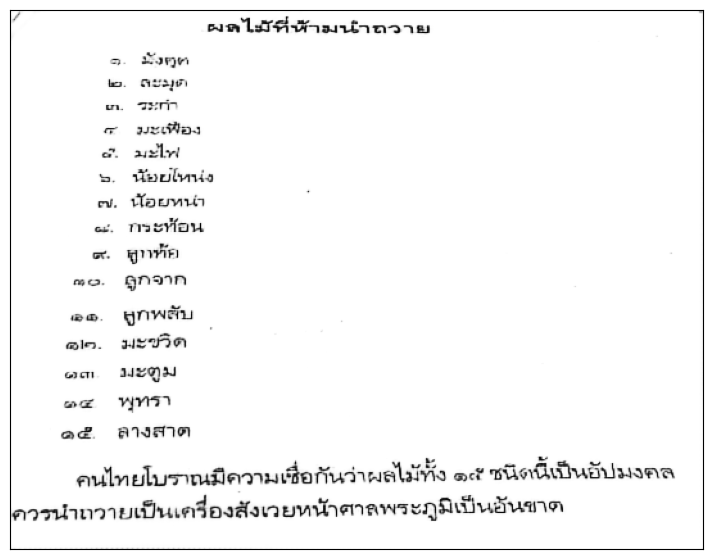

In [8]:
Y_pred = loaded_autoencoder.predict(img) # เรียกใช้ loaded_autoencoder ที่ load มาก่อนหน้านี้
Y_pred = np.squeeze(Y_pred)
print(Y_pred.shape)

# รูปที่ได้
plt.figure(figsize=(10, 7))
plt.imshow(Y_pred, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

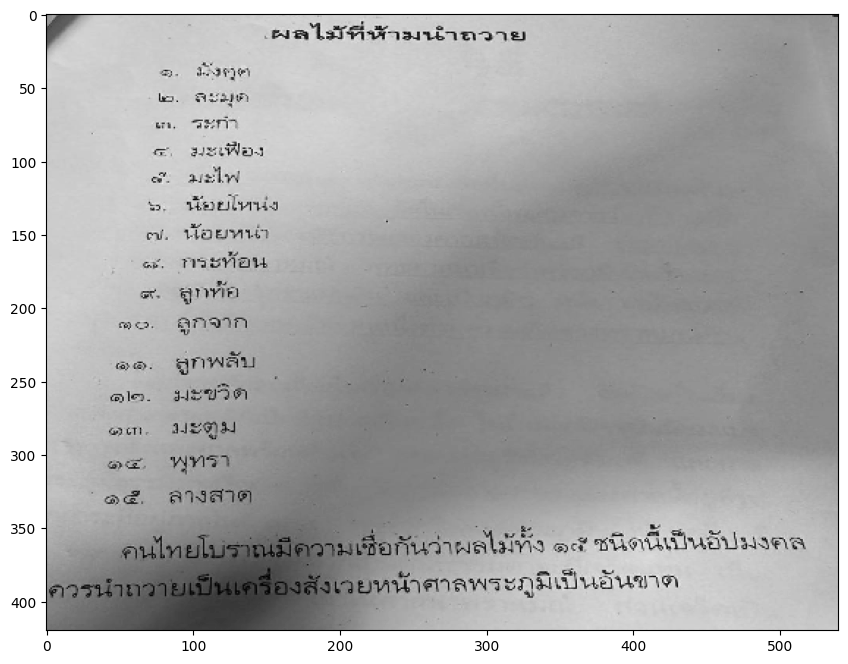

In [9]:
# รูปเดิม
plt.figure(figsize=(12, 8))
plt.imshow(np.squeeze(img), cmap='gray')
plt.show()

## วน for loop save img ใน folder

In [ ]:
import os
import matplotlib.pyplot as plt

imgW, imgH = 540, 420

# ที่อยู่ของโฟลเดอร์ที่มีรูป
folder_path = '/content/drive/MyDrive/ColabNotebooks/denoising-dirty-documents/test'

# ดึงรายการไฟล์ทั้งหมดในโฟลเดอร์
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for image_file in image_files:

    image_path = os.path.join(folder_path, image_file)

    img = load_img(image_path, target_size=(imgH, imgW), color_mode='grayscale') # อ่านเป็น grayscale
    img = img_to_array(img) # เปลี่ยนเป็น array
    img = img/255.0 # normalize ภาพ

    img = np.expand_dims(img, axis=0) # reshape ให้เป็นข้อมูล 1 row (1 sample) ให้เป็น (1,420,540,1)

    Y_pred = loaded_autoencoder.predict(img) # เรียกใช้ loaded_autoencoder ที่ load มาก่อนหน้านี้
    Y_pred = np.squeeze(Y_pred)

    # รูปที่ได้
    plt.figure(figsize=(10, 7))
    plt.imshow(Y_pred, cmap='gray')
    plt.xticks([]), plt.yticks([])

    # บันทึกรูป
    output_path = os.path.join('/content/drive/MyDrive/ColabNotebooks/denoising-dirty-documents/test_result', f'{image_file.split(".")[0]}_plot.png')
    plt.savefig(output_path)

    # แสดงรูป
    # plt.show() # ตรงนี้ขอไม่แสดงเพราะหลายรูปมาก


## หมายเหตุ:

รูป หรือ output ที่ได้จาก autoencoder จะมีมิติเท่ากับ ต้นฉบับ หรือ input แต่รายละเอียดภายในของรูปที่ได้จะไม่คมชัดเท่ากับต้นฉบับ 